In [1]:
import numpy as np
import pandas as pd

#PCA Weights from a risk distribution R
def pcaWeights(cov, riskDist=None, riskTarget=1.):
    #Following the riskAlloc distribution, match riskTarget
    eVal, eVec = np.linalg.eigh(cov) #must be hermitian
    indices = eVal.argsort()[::-1] #arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:,indices]
    if riskDist is None:
        riskDist = np.zeros(cov.shape[0])
        riskDist[-1] = 1
    loads = riskTarget * (riskDist/eVal)**.5
    wghts = np.dot(eVec, np.reshape(loads, (-1, 1)))
    #ctr = (loads/riskTarget)**2*eVal # verify riskDist
    return wghts

In [2]:
#single future roll
#approach is to form a time series of cumulative roll gaps, and detract the gap series from the price series 
#FUT_CUR_GEN_TICKER = identifies the contract associated with that price. Its value changes with every roll
#PX_OPEN = the open price associated with that bar
#PX_LAST = the close price associated with the bar 
#VWAP = the volume weighted average price associated with that bar 
#takes HDF5 table of tick bars
def getRolledSeries(pathIn, key):
    series = pd.read_hdf(pathIn, key='bars/ES_10k')
    series['Time'] = pd.to_datetime(series['Time'], format='%Y%m%d%H%M%S%f')
    series = series.set_index('Time')
    gaps = rollGaps(series)
    for fld in ['Close', 'VWAP']:
        series[fld]-=gaps
    return series
def rollGaps(series, dictio={'Instrument':'FUT_CUR_GEN_TICKER', 'OPEN':'PX_OPEN','CLOSE':'PX_LAST'}, matchEnd=True):
    #compute gaps at each roll, between previous close and next open
    rollDates = series[dictio['Instrument']].drop_duplicates(keep='first').index
    gaps = series[dictio['Close']]*0
    iloc = list(series.index)
    iloc = [iloc.index(i)-1 for i in rollDates] #index of days prior to roll
    gaps.loc[rollDates[1:]] = series[dictio['Open']].loc[rollDates[1:]] - series[dictio['Close']].iloc[iloc[1:]].values
    gaps = gaps.cumsum()
    if matchEnd:
        gaps-=gaps.iloc[-1] #roll backward
    return gaps

In [3]:
def priceSeries(filePath):
    raw = pd.read_csv(filePath, index_col=0, parse_dates=True)
    gaps = rollGaps(raw, dictio={'Instrument':'Symbol', 'Open':'Open', 'Close': 'Close'})
    rolled = raw.copy(deep=True)
    for fld in ['Open', 'Close']:
        rolled[fld]-=gaps
    rolled['Returns']=rolled['Close'].diff()/raw['Close'].shift(1)
    rolled['rPrices']=(1+rolled['Returns']).cumprod()

In [4]:
#the symmetric CUSUM Filter
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [],0,0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndec(t.Events)

In [5]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
# raw trade data from https://public.bitmex.com/?prefix=data/trade/ 
data = pd.read_csv("20181127.csv")
data = data.append(pd.read_csv("20181128.csv")) # add a few more days
data = data.append(pd.read_csv("20181129.csv"))
data = data[data.symbol == "XBTUSD"]
# timestamp parsing
data["timestamp"] = data.timestamp.map(lambda t: datetime.strptime(t[:-3], '%Y-%m-%dD%H:%M:%S.%f'))

In [6]:
#volume weighted average price 15 minute intervals
def compute_vwap(df):
    q = df['foreignNotional']
    p = df['price']
    vwap = np.sum(p * q) / np.sum(q)
    df['vwap'] = vwap
    return df

data_timeidx = data.set_index('timestamp')
data_time_grp = data_timeidx.groupby(pd.Grouper(freq='15Min'))
data_time_vwap = data_time_grp.apply(compute_vwap)


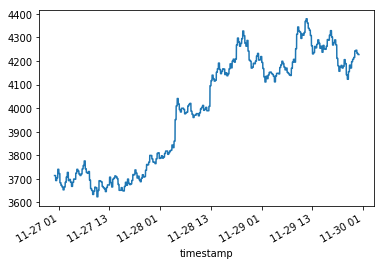

In [7]:
data_time_vwap['vwap'].plot()

In [10]:
#tick bars by number of transactions 
total_ticks = len(data)
num_time_bars = len(data_time_grp)
num_ticks_per_bar = total_ticks / num_time_bars
num_ticks_per_bar = round(num_ticks_per_bar, -3) # round to the nearest thousand
data_tick_grp = data.reset_index().assign(grpId=lambda row: row.index // num_ticks_per_bar)
data_tick_vwap =  data_tick_grp.groupby('grpId').apply(compute_vwap)
data_tick_vwap.set_index('timestamp', inplace=True)

In [ ]:
data

In [11]:
data_tick_grp

,index,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,grpId
0,218349,2018-11-27 00:00:03.851282,XBTUSD,Buy,10,3724.5,ZeroPlusTick,538c244f-a1a9-61db-da2e-6db7b76e7507,268490,0.002685,10.0,-0.0
1,218350,2018-11-27 00:00:04.250260,XBTUSD,Buy,20,3724.5,ZeroPlusTick,c50cf101-1c0d-445f-42c4-fc5339641968,536980,0.005370,20.0,0.0
2,218351,2018-11-27 00:00:04.250260,XBTUSD,Buy,480,3724.5,ZeroPlusTick,b71da1f1-b76e-c1e5-59ab-765438000186,12887520,0.128875,480.0,0.0
3,218352,2018-11-27 00:00:04.255471,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,f7741936-b74c-844b-5023-a85712fe819e,26849000,0.268490,1000.0,0.0
4,218353,2018-11-27 00:00:04.262041,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,9f5d581b-0eef-4dcd-16a2-019488ec38b8,26849000,0.268490,1000.0,0.0
5,218354,2018-11-27 00:00:04.681458,XBTUSD,Sell,1390,3724.0,MinusTick,10a18b3c-abe8-3b13-aca3-5a35a76dc38c,37325670,0.373257,1390.0,0.0
6,218355,2018-11-27 00:00:04.681458,XBTUSD,Sell,3610,3724.0,ZeroMinusTick,241b138a-5e71-32a1-d428-658b63d95b57,96939330,0.969393,3610.0,0.0
7,218356,2018-11-27 00:00:04.748939,XBTUSD,Sell,4000,3724.0,ZeroMinusTick,1831e2d5-a821-4844-fc81-2ffafe8fcb33,107412000,1.074120,4000.0,0.0
8,218357,2018-11-27 00:00:04.755321,XBTUSD,Sell,80000,3724.0,ZeroMinusTick,53de3037-7062-ba26-10a0-6ca10980240b,2148240000,21.482400,80000.0,0.0
9,218358,2018-11-27 00:00:04.870969,XBTUSD,Buy,1,3724.5,PlusTick,c203b0c7-ec4e-5669-c832-eb042da4cf6f,26849,0.000268,1.0,0.0


In [50]:
#volume bars
data_cm_vol = data.assign(cmVol=data['homeNotional'].cumsum())
total_vol = data_cm_vol.cmVol.values[-1]
vol_per_bar = total_vol / num_time_bars
vol_per_bar = round(vol_per_bar, -2)

data_vol_grp = data_cm_vol.assign(grpId = lambda row: row.cmVol // vol_per_bar)

data_vol_vwap =  data_vol_grp.groupby('grpId').apply(compute_vwap)
data_vol_vwap.set_index('timestamp', inplace=True)


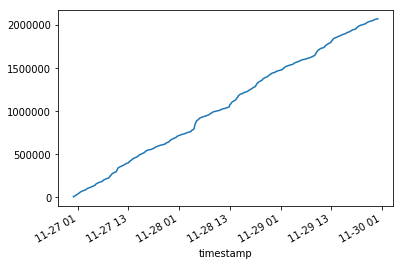

In [59]:
data_vol_vwap['cmVol'].plot()